In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv
import math
import ktrain
from keras_lr_finder import LRFinder
import sys

In [2]:
sys.path.insert(1, '/home/houcem/git/CLR')

In [3]:
from clr_callback import *

# Creating a generator to load and preprocess the images

In [4]:
train_csv_path = "/home/houcem/data/combined_csv.csv"
val_csv_path = "/home/houcem/data_val/data.csv"
train_sample_size = sum(1 for row in open(train_csv_path))
val_sample_size = sum(1 for row in open(val_csv_path))
path = "/home/houcem/data/data.csv"

In [5]:
batch_size = 50

In [6]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

In [7]:
def babbling_generator(csv_path, batch_size):
    X_train = []
    y_train = []
    motor_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([float(throttle), float(steering_angle)])
                
                #Loading and Normalizing the target frame
                img_y = cv2.imread(str(img_y_path).rstrip("\n"))
                img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                motor_train.append(motor_input)
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    motor_train = np.asarray(motor_train)                    
                    y_train = np.asarray(y_train)
                    yield([X_train, motor_train], y_train)
                    X_train = []
                    y_train = []
                    motor_train = []
                    batchcount = 0

In [8]:
def train_generator(csv_path, batch_size):
    X_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    yield(X_train)
                    X_train = []
                    batchcount = 0

In [9]:
def train_y_generator(csv_path, batch_size):
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                #img_x = imread(str(img_x_path))
                #img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                img_y = cv2.imread(img_y_path.rstrip("\n"))
                img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    y_train = np.asarray(y_train)
                    yield(y_train)
                    y_train = []
                    batchcount = 0

In [10]:
def motor_parser(csv_path):
    motor_input = []
    f = open(csv_path)
    next(f)
    for line in f:
        img_x_path, throttle, steering_angle, img_y_path = line.split(',')
        motor_input.append(np.asarray([throttle, steering_angle]))
    return np.asarray(motor_input)        

# Defining the model

In [11]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
#tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [12]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D, LeakyReLU
from keras.activations import relu, linear, selu
from keras import Model
from keras import backend as K
from keras.losses import mae 
from keras.callbacks import TensorBoard

In [14]:
image_input = Input(shape=(112,112,3))
x = Conv2D(8, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(image_input)
x = BatchNormalization()(x)
x = Conv2D(8, (3,3), activation = selu, strides = 2, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3,3), activation = selu, strides = 2, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = selu, strides = 2, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = selu, strides = 2, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = Flatten()(x)

z = Dense(128, activation = 'sigmoid', activity_regularizer = keras.regularizers.l1(1e-4))(x)

encoder = Model(inputs= [image_input], outputs = [z])

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 8)       216       
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 8)       32        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 8)         576       
_________________________________________________________________
batch_normalization_9 (Batch (None, 56, 56, 8)         32        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 16)        1152      
_________________________________________________________________
batch_normalization_10 (Batc (None, 56, 56, 16)        64  

In [15]:
input_decoder = Input(shape=(128,))

dense_1= Dense(3136, activation = selu, activity_regularizer = keras.regularizers.l2(1e-4), kernel_initializer=keras.initializers.he_uniform())(input_decoder)
d = Reshape((7,7,64))(dense_1)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
d = UpSampling2D()(d)
d = Conv2D(8,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='linear', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [16]:
Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 64)        36864     
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0   

# Creating the autoencoder

In [17]:
img_input = Input(shape=(112, 112, 3))
Encoded = encoder([img_input])
Decoded = Decoder(Encoded)

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [18]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
model_1 (Model)              (None, 128)               475864    
_________________________________________________________________
model_2 (Model)              (None, 112, 112, 3)       466299    
Total params: 942,163
Trainable params: 941,443
Non-trainable params: 720
_________________________________________________________________


# Autoencoder training

In [19]:
def SSIM_l1_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true,y_pred, max_val=1, filter_size=3)) + mae(y_true, y_pred)

In [20]:
autoencoder.compile(loss = SSIM_l1_loss, optimizer= keras.optimizers.Adam(learning_rate=1e-3)) 

In [21]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

In [22]:
autoencoder.fit(generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 50, validation_data= generator(val_csv_path, batch_size), validation_steps= val_sample_size/batch_size, callbacks= [tensorboard])

Epoch 1/50
2299/2298 [==============================] - 583s 254ms/step - loss: 0.5542 - val_loss: 0.2978
Epoch 2/50
2299/2298 [==============================] - 180s 78ms/step - loss: 0.4569 - val_loss: 0.3011
Epoch 3/50
2299/2298 [==============================] - 181s 79ms/step - loss: 0.4369 - val_loss: 0.2890
Epoch 4/50
2299/2298 [==============================] - 182s 79ms/step - loss: 0.3982 - val_loss: 0.2801
Epoch 5/50
2299/2298 [==============================] - 182s 79ms/step - loss: 0.3571 - val_loss: 0.2472
Epoch 6/50
2299/2298 [==============================] - 182s 79ms/step - loss: 0.3370 - val_loss: 0.2328
Epoch 7/50
2299/2298 [==============================] - 182s 79ms/step - loss: 0.3239 - val_loss: 0.2097
Epoch 8/50
2299/2298 [==============================] - 183s 80ms/step - loss: 0.3151 - val_loss: 0.2197
Epoch 9/50
2299/2298 [==============================] - 184s 80ms/step - loss: 0.3083 - val_loss: 0.2036
Epoch 10/50
2299/2298 [==============================]

In [23]:
autoencoder.save_weights("autoencoder_babbling_sigmoid_strided_l1.h5")

# Let's check out the prediction for the first image

In [24]:
csv_file = open(train_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [25]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [26]:
showed_image = imread(img_x_path)

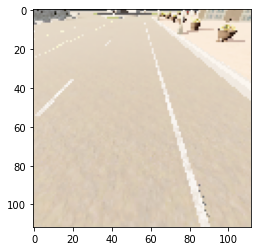

In [43]:
plt.imshow(showed_image)

In [44]:
img = imread(img_x_path)
img = img/255.0
img = img.reshape([1,112,112,3])

In [45]:
result = autoencoder.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


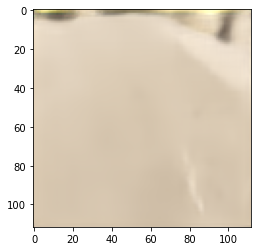

In [46]:
plt.imshow(result.reshape([112,112,3]))

# Building the motor babbling MLP

In [291]:
autoencoder.load_weights("autoencoder_babbling_sigmoid_regularized.h5") 

In [54]:
autoencoder.trainable = False

In [116]:
latent_input = Input(shape=(128,))

motor_input = Input(shape=(2,))

babbling_input = Concatenate()([latent_input, motor_input])

z = Dense(512, activation = selu, activity_regularizer= keras.regularizers.l2(1e-4), kernel_initializer = keras.initializers.he_uniform())(babbling_input)
z = Dense(128, activation = 'sigmoid', activity_regularizer= keras.regularizers.l1(1e-4))(z)

babbling_mlp = Model(inputs = [latent_input, motor_input], outputs = z)

In [117]:
babbling_mlp.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 130)          0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          67072       concatenate_1[0][0]        

# Let's train it and see the results 

In [118]:
babbling_mlp.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate=1e-4))

In [119]:
train_X = encoder.predict(train_generator(path, batch_size), steps = train_sample_size/batch_size)

In [120]:
train_X = train_X[0:50000,:]

In [121]:
train_y = encoder.predict(train_y_generator(path, batch_size), steps = train_sample_size/batch_size)

In [122]:
train_y = train_y[0:50000, :]

In [123]:
import pickle

data = open("/home/houcem/data/motor_output.p", "rb+")
unpickler = pickle.Unpickler(data)
training = unpickler.load()
data.close()

In [124]:
training = np.asarray(training)

In [125]:
babbling_mlp.fit(x=[train_X, training], y= train_y, epochs=4)

Epoch 1/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0176
Epoch 2/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0026
Epoch 3/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0017
Epoch 4/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0012


In [126]:
img_input = Input(shape=(112, 112, 3), name = "img")
motor_input = Input(shape=(2,), name = "motor")

Encoded = encoder([img_input])
babbling = babbling_mlp([Encoded, motor_input])
Decoded = Decoder(babbling)

babbling_model = Model(inputs = [img_input, motor_input], outputs = Decoded)

# Let's finetune the entire model

In [127]:
encoder.trainable = False

In [128]:
babbling_model.compile(loss = SSIM_l1_loss, optimizer = keras.optimizers.Adam(learning_rate = 1e-5))

In [130]:
babbling_model.fit(babbling_generator(train_csv_path, batch_size), steps_per_epoch= train_sample_size/batch_size, validation_data=babbling_generator(val_csv_path,batch_size), validation_steps=val_sample_size/batch_size, epochs = 5)

Epoch 1/5
2299/2298 [==============================] - 180s 78ms/step - loss: 0.3978 - val_loss: 0.2520
Epoch 2/5
2299/2298 [==============================] - 181s 79ms/step - loss: 0.3940 - val_loss: 0.2509
Epoch 3/5
2299/2298 [==============================] - 180s 78ms/step - loss: 0.3907 - val_loss: 0.2498
Epoch 4/5
2299/2298 [==============================] - 180s 78ms/step - loss: 0.3879 - val_loss: 0.2488
Epoch 5/5
2299/2298 [==============================] - 182s 79ms/step - loss: 0.3853 - val_loss: 0.2483


In [131]:
babbling_model.save_weights("babbling_model_babbling_strided_SSIM.h5")

In [33]:
babbling_model.load_weights("babbling_model_direct_adam.h5")

ValueError: Layer #1 (named "model_10" in the current model) was found to correspond to layer model_6 in the save file. However the new layer model_10 expects 6 weights, but the saved weights have 4 elements.

In [36]:
x_paths = sorted(glob.glob("/home/houcem/data_val/rgb/*.png"))

In [37]:
def display_results(x_paths, training, predictions, i):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10,18))
    
    #Showing the image at instant t
    img_t = imread(str(x_paths[i]))
    ax.flat[0].imshow(img_t)
    
    #showing the image at instant t+1
    img_t1 = imread(str(x_paths[i+1]))
    ax.flat[1].imshow(img_t1)
    
    #showing the predicted image
    ax.flat[2].imshow(predictions[i])
    
    plt.show()
    
    print('Throttle ', training[i][0])
    print('Steering Angle', training[i][1])

In [38]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [39]:
interact(display_results, x_paths=fixed(x_paths), training=fixed(test), predictions=fixed(predictions), i=widgets.IntSlider(min=0, max=9999, step=1, value=10))

NameError: name 'test' is not defined